# Comparing with Experimental Data

In this notebook we show how to compare results generated in PyBaMM with experimental data. We compare the results of the DFN model (see the [DFN notebook](./models/DFN.ipynb)) with the experimental data from Ecker et. al. [[3]](#References). Results are compared for a constant current discharge at 1C and at 5C.

First we import pybamm and any other packages required by this example, and then change our working directory to the root of the pybamm folder.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


We then load the Ecker data in from the `.csv` files using `pandas`

In [2]:
voltage_data_1C = pd.read_csv("pybamm/input/discharge_data/Ecker2015/Ecker_1C.csv", header=None).to_numpy()
voltage_data_5C = pd.read_csv("pybamm/input/discharge_data/Ecker2015/Ecker_5C.csv", header=None).to_numpy()

Note that the data is Time [s] vs Voltage [V].

We load the DFN model and select the parameter set from the Ecker paper [1]. We update the C-rate an `InputParameter` so that we can re-run the same model at different C-rates without the need to rebuild the model. This is done by passing the flag `[input]`.

In [4]:
# choose DFN
model1 = pybamm.lithium_ion.SPMe()
model2 = pybamm.lithium_ion.DFN()

# pick parameters, keeping C-rate as an input to be changed for each solve
parameter_values = pybamm.ParameterValues("Ecker2015")
parameter_values.update({"Current function [A]": "[input]"})

For this comparison we choose a fine mesh of 1 finite volume per micron in the electrodes and separator and 1 finite volume per 0.1 micron in the particles

In [6]:
var = pybamm.standard_spatial_vars
var_pts = {
    var.x_n: int(parameter_values.evaluate(model2.param.n.L / 1e-6)),
    var.x_s: int(parameter_values.evaluate(model2.param.s.L / 1e-6)),
    var.x_p: int(parameter_values.evaluate(model2.param.p.L / 1e-6)),
    var.r_n: int(parameter_values.evaluate(model2.param.n.prim.R_typ / 1e-7)),
    var.r_p: int(parameter_values.evaluate(model2.param.p.prim.R_typ / 1e-7)),
}

We create a simulation using our model, parameters and number of grid points

In [7]:
sim1 =  pybamm.Simulation(model1, parameter_values=parameter_values, var_pts=var_pts)
sim2 =  pybamm.Simulation(model2, parameter_values=parameter_values, var_pts=var_pts)

We can then solve the model for a 1C and 5C discharge 

In [8]:
C_rates = [1, 5]  # C-rates to solve for
capacity = parameter_values["Nominal cell capacity [A.h]"]
t_evals = [
    np.linspace(0, 3800, 100), 
    np.linspace(0, 720, 100)
] # times to return the solution at
solutions1 = [None] * len(C_rates)  # empty list that will hold solutions
solutions2 = [None] * len(C_rates)  # empty list that will hold solutions

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions1[i] = sim1.solution
    sim2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions2[i] = sim2.solution

Finally we plot the numerical solution against the experimental data

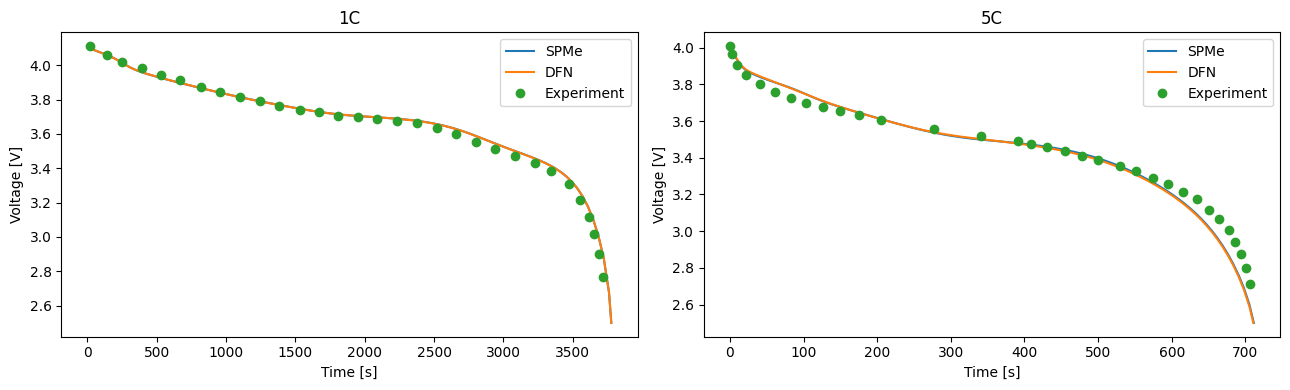

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t1 = solutions1[0]["Time [s]"].entries
t2 = solutions2[0]["Time [s]"].entries
ax1.plot(t1, solutions1[0]["Terminal voltage [V]"](t1))
ax1.plot(t2, solutions2[0]["Terminal voltage [V]"](t2))
ax1.plot(voltage_data_1C[:,0], voltage_data_1C[:,1], "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("1C")
ax1.legend(["SPMe", "DFN", "Experiment"], loc="best")

# plot the 5C results
t1 = solutions1[1]["Time [s]"].entries
t2 = solutions2[1]["Time [s]"].entries
ax2.plot(t1, solutions1[1]["Terminal voltage [V]"](t1))
ax2.plot(t2, solutions2[1]["Terminal voltage [V]"](t2))
ax2.plot(voltage_data_5C[:,0], voltage_data_5C[:,1], "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Voltage [V]")
ax2.set_title("5C")
ax2.legend(["SPMe", "DFN", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

For a 1C discharge we observe an excellent agreement between the model and experiment, both in terms of the overall shape of the curve and the capacity. The agreement between model and experiment is less good at 5C, but in line with other implementations of the DFN (e.g. [[6]](#References)). 

## References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()